In [3]:
import os
import random
import matplotlib.pyplot as plt
import cv2
from collections import Counter


In [4]:
# Pfad zum Dataset anpassen falls nötig
data_dir = "../data"   

classes = ["glioma", "meningioma", "no_tumor", "pituitary"]


In [5]:
image_counts = {}
for cls in classes:
    folder = os.path.join(data_dir, cls)
    files = [f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    image_counts[cls] = len(files)

print("Bilder pro Klasse:", image_counts)


Bilder pro Klasse: {'glioma': 3754, 'meningioma': 2343, 'no_tumor': 1757, 'pituitary': 2706}


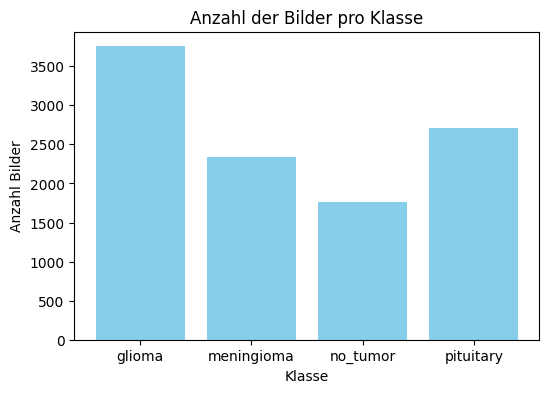

In [6]:
plt.figure(figsize=(6,4))
plt.bar(image_counts.keys(), image_counts.values(), color="skyblue")
plt.title("Anzahl der Bilder pro Klasse")
plt.xlabel("Klasse")
plt.ylabel("Anzahl Bilder")
plt.show()


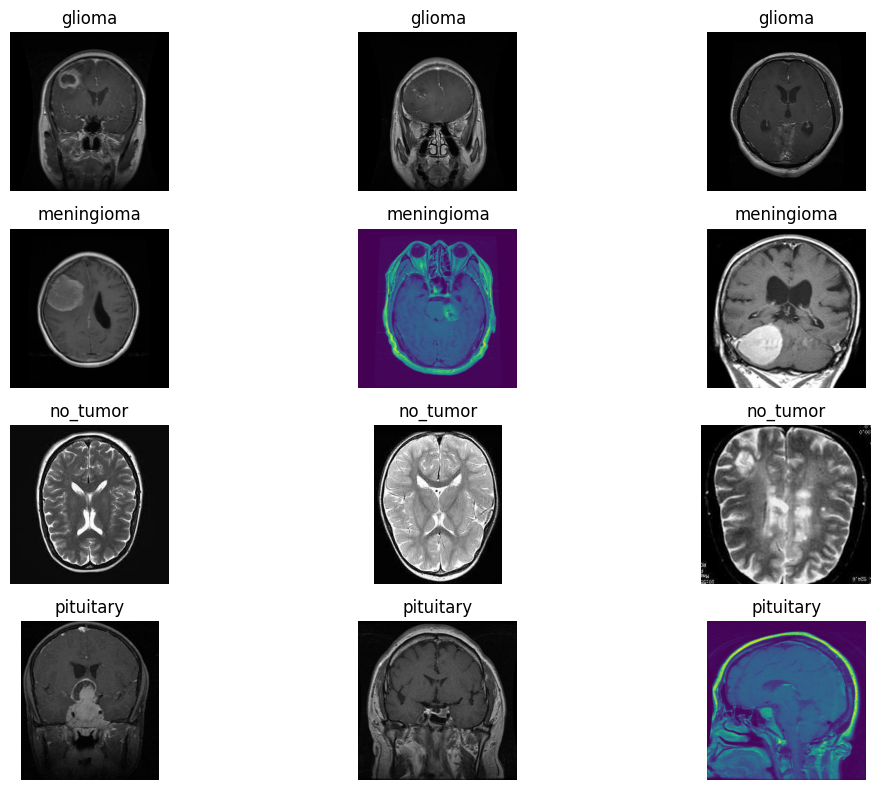

In [7]:
plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes):
    folder = os.path.join(data_dir, cls)
    files = [f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    sample_files = random.sample(files, min(3, len(files)))  # 3 zufällige pro Klasse

    for j, file in enumerate(sample_files):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(classes), 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # alle Bilder auf 128x128 bringen
    transforms.ToTensor(),           # zu PyTorch Tensor konvertieren
    transforms.Normalize(            # Werte normalisieren
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])


In [10]:
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, classes, transform=None):
        self.data_dir = data_dir
        self.classes = classes
        self.transform = transform

        self.images = []
        self.labels = []

        for idx, cls in enumerate(classes):
            folder = os.path.join(data_dir, cls)
            for file in os.listdir(folder):
                if file.lower().endswith((".jpg", ".png", ".jpeg")):
                    self.images.append(os.path.join(folder, file))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [11]:
dataset = BrainTumorDataset(data_dir, classes, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Anzahl Bilder im Dataset:", len(dataset))


Anzahl Bilder im Dataset: 10560


In [12]:
images, labels = next(iter(dataloader))
print("Batch Shape:", images.shape)
print("Labels:", labels[:10])


Batch Shape: torch.Size([32, 3, 128, 128])
Labels: tensor([0, 1, 3, 3, 3, 2, 3, 0, 0, 2])


In [13]:
images, labels = next(iter(dataloader))
print("Batch Shape:", images.shape)
print("Labels:", labels[:10])


Batch Shape: torch.Size([32, 3, 128, 128])
Labels: tensor([3, 0, 1, 3, 0, 1, 3, 0, 1, 2])


In [14]:
import torch.nn as nn
import torch.optim as optim

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # 128x128 → nach 2x Pooling → 32x32
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleCNN(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


In [17]:
epochs = 3  # zum Testen erstmal klein halten
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Accuracy: {acc:.2f}%")


Epoch 1, Loss: 213.866, Accuracy: 74.73%
Epoch 2, Loss: 112.891, Accuracy: 86.53%
Epoch 3, Loss: 61.212, Accuracy: 93.00%
